In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

We'll simulate a datset of value-based choices. On each trial, the participant is given three items to choose
between, and we know their true values. Each row in `choice_problem` represents one such problem.
We assume that the true data generating process is a softmax, i.e. people noisly maximize the value of
the chosen item.

In [2]:
from numpy.random import randn, choice
TRUE_TEMP = 0.5
choice_problems = randn(100, 3)  # each row is one choice between 3 items
def softmax(x, temp):
    ex = np.exp((x - x.max(-1, keepdims=True)) / temp)
    return ex / ex.sum(-1, keepdims=True)

choice_probs = softmax(choice_problems, TRUE_TEMP)
choices = np.array([choice(range(3), p=cp) for cp in choice_probs])

# Model

Now imagine we have a pretty bad model that assumes people always choose the best option.
The probability of this model will be 0 because it assigns 0 probability to an error, so
even one non-optimal choice in the dataset will give the whole dataset 0 probability.

In [3]:
def model(x):
    return np.argmax(x)

predictions = np.array([model(x) for x in choice_problems])
model_p = predictions == choices
print('Percent correct predictions:', 100*np.mean(model_p))
print('Likelihood:', np.prod(model_p))

Percent correct predictions: 74.0
Likelihood: 0


## Accounting for errors

The simplest way to account for errors is to use a mixture model. One component is the model prediction, 
and the other is a random prediction. We can then fit the mixture weight to the data. This weight
corresponds to the ratio of trials that are explained by the model vs. treated as random.

(49, 100)


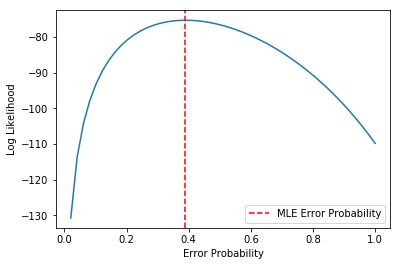

In [4]:
rand_p = 1 / len(choice_problems[0])  # probability of choosing randomly
def noisy_model_p(p_err):
    return (1 - p_err) * model_p + p_err * rand_p

p_err = np.linspace(0,1)[1:]
# Note the indexing trick: p_err[:, None]
# This creates a new dimension on the array so that we can use broadcasting
# and do all the computations with fast vectorized numpy operations.
logp = np.log(noisy_model_p(p_err[:, None]))
print(logp.shape)
total_logp = logp.sum(-1)  # sum logp across trials
i = np.argmax(total_logp)
best_p_err = p_err[i]

plt.plot(p_err, total_logp)
plt.xlabel('Error Probability')
plt.ylabel('Log Likelihood')
plt.axvline(best_p_err, c='r', ls='--', label='MLE Error Probability')
plt.legend()

## Softmax model

We can do something similar to fit the temperature of the true generating process, a softmax.
Hopefully we recover something close to the true temperature. The softmax model is generally
a good choice when your model predicts the utility or value of different choices, e.g. Q values
in reinforcement learning. Obviously, it's a great choice when the "data" is actually generated
by a softmax!

(50,)
(50, 100, 3)


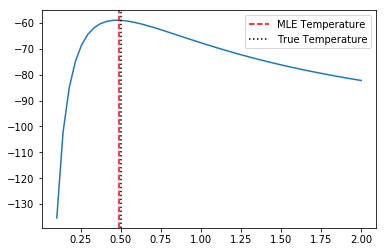

In [5]:
temp = np.linspace(0.1, 2)
print(temp.shape)
predicted_choice_probs = softmax(choice_problems, temp[:, None, None])
print(predicted_choice_probs.shape)
softmax_logp = np.log(predicted_choice_probs[:, np.arange(100), choices])
total_logp = softmax_logp.sum(-1)
i = np.argmax(total_logp)
best_temp = temp[i]

plt.plot(temp, total_logp)
plt.axvline(best_temp, c='r', ls='--', label='MLE Temperature')
plt.axvline(TRUE_TEMP, c='k', ls=':', label='True Temperature')
plt.legend()